#Malawi Mesonet Applicability

This example follows the same procedure as the previous example in Minnesota. However, in my mind, that consistency is powerful - showing not only the vast world of data that we now live in, but the quality of the data analysis processes.

One goal of this research project was to systematize the placement of climate sensors

In [22]:
#Import packages
import rasterio
import rasterio.features
import rasterio.warp
import requests
from zipfile import ZipFile
import fiona
import geopandas as gpd
import numpy as np

In [20]:
# Source urls
elevationURL = 'https://resources.gisdata.mn.gov/pub/gdrs/data/pub/us_mn_state_dnr/elev_30m_digital_elevation_model/fgdb_elev_30m_digital_elevation_model.zip'
landcoverURL = 'https://resources.gisdata.mn.gov/pub/gdrs/data/pub/us_mn_state_dnr/biota_landcover_nlcd_mn_2016/tif_biota_landcover_nlcd_mn_2016.zip'

In [9]:
from rasterio.plot import show
#show(elevation)

In [49]:
#landcover = rasterio.open('NLCD_2011_MN_Landcover.tif')
#show(landcover)

In [50]:
#!pip install shapely
#!pip install pycrs

In [2]:
Malawi_border = gpd.read_file("Malawi_Border/malawi_adm0.shp")

In [174]:
Malawi = Malawi_border
Minnesota

,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
3,2,4,27,00662849,27,MN,Minnesota,00,G4000,A,206232157570,18949864226,+46.3159573,-094.1996043,"POLYGON ((210324.633 5171063.920, 210328.118 5..."


In [175]:
Malawi = Malawi.to_crs(26915)

In [176]:
#Exporting Minnesota borders to shapefile
Malawi.to_file('Malawi.shp', driver='ESRI Shapefile')

### Masking not required for Malawi because they have the same size

In [ ]:
#Masking elevation data to Minnesota borders
import fiona
import rasterio
import rasterio.mask
    
with fiona.open("Malawi.shp", "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

with rasterio.open("Malawi Elevation/Malawi_SRTM30meters.tif") as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta

out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open("Malawi_elev_masked.tif", "w", **out_meta) as dest:
    dest.write(out_image)

In [4]:

from osgeo import gdal
from gdalconst import GA_ReadOnly

maskDs = gdal.Open('/Malawi_Elevtion/Malawi_SRTM30meters.tif', GA_ReadOnly)# your mask raster
projection=maskDs.GetProjectionRef()
geoTransform = maskDs.GetGeoTransform()
minx = geoTransform[0]
maxy = geoTransform[3]
maxx = minx + geoTransform[1] * maskDs.RasterXSize
miny = maxy + geoTransform[5] * maskDs.RasterYSize


data=gdal.Open('/Malawi_Landcover/Malawi_Landcover_2010_Scheme_I.tif', GA_ReadOnly) #Your data the one you want to clip
output='output.tif' #output file
gdal.Translate(output,data,format='GTiff',projWin=[minx,maxy,maxx,miny],outputSRS=projection)

ModuleNotFoundError: No module named 'gdalconst'

In [14]:
#Masking landcover data to Malawi borders
import fiona
import rasterio
import rasterio.mask
    
with fiona.open("Malawi.shp", "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

with rasterio.open("Malawi_Landcover/Malawi_Landcover_2010_Scheme_I.tif") as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta

out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open("Malawi_NLCD_masked.tif", "w", **out_meta) as dest:
    dest.write(out_image)

## Slope

In [3]:
from rasterio.plot import show_hist
from rasterio.mask import mask
from shapely.geometry import box
from fiona.crs import from_epsg
import pycrs

In [116]:
#!pip install ospybook-latest.zip

In [4]:
# Script to compute slope from a DEM.
# From "Geoprocessing with Python" by Chris Garrard (p. 253)

import os
import numpy as np
from osgeo import gdal
import ospybook as pb

in_fn = 'Malawi_Elevation/Malawi_SRTM30meters.tif'
out_fn = 'Malawi_Slopes.tif'

# Get cell width and height.
in_ds = gdal.Open(in_fn)
cell_width = in_ds.GetGeoTransform()[1]
cell_height = in_ds.GetGeoTransform()[5]

# Read the data into a floating point array.
band = in_ds.GetRasterBand(1)
in_data = band.ReadAsArray().astype(float)

# Initialize the output array with -99.
out_data = np.ones((band.YSize, band.XSize)) * -99

# Make the slices.
slices = pb.make_slices(in_data, (3, 3))

# Compute the slope using the equations from the text.
rise = ((slices[6] + (2 * slices[7]) + slices[8]) -
        (slices[0] + (2 * slices[1]) + slices[2])) / \
       (8 * cell_height)
run =  ((slices[2] + (2 * slices[5]) + slices[8]) -
        (slices[0] + (2 * slices[3]) + slices[6])) / \
       (8 * cell_width)
dist = np.sqrt(np.square(rise) + np.square(run))

# The output from the last equation is inserted into the middle
# of the output array, ignoring the edges again.
out_data[1:-1, 1:-1] = np.arctan(dist) * 180 / np.pi

# Save the data.
pb.make_raster(in_ds, out_fn, out_data, gdal.GDT_Float32, -99)
del in_ds

In [7]:
import matplotlib.pyplot as plt

plt.imshow(out_data, cmap="GnBu")

NameError: name 'out_data' is not defined

In [8]:
# Convert array to .tif
ds = gdal.Open("Malawi_Elevation/Malawi_SRTM30meters.tif")
gt = ds.GetGeoTransform()
proj = ds.GetProjection()

driver = gdal.GetDriverByName("GTiff")
driver.Register()
outds = driver.Create("out_data.tif",xsize = out_data.shape[1],ysize = out_data.shape[0],bands=1,eType = gdal.GDT_Int16)

outds.SetGeoTransform(gt)
outds.SetProjection(proj)
outband = outds.GetRasterBand(1)

outband.WriteArray(out_data)

outband.SetNoDataValue(np.nan)

outband.FlushCache()

outband = None
outds = None

In [13]:
out_data.shape

NameError: name 'out_data' is not defined

In [181]:
Study_Area_Slope = out_data
Study_Area_Slope.shape

(27964, 11672)

#### Reclassify appropriate and inappropriate slopes

In [23]:
ds_slopes = gdal.Open('Malawi_Slopes.tif')
ds_slopes

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f9cf13f7210> >

In [24]:
band_slopes = ds_slopes.GetRasterBand(1)
band_slopes

<osgeo.gdal.Band; proxy of <Swig Object of type 'GDALRasterBandShadow *' at 0x7f9cf1387bd0> >

In [25]:
array_slopes = band_slopes.ReadAsArray()
array_slopes

array([[-99., -99., -99., ..., -99., -99., -99.],
       [-99.,   0.,   0., ...,   0.,   0., -99.],
       [-99.,   0.,   0., ...,   0.,   0., -99.],
       ...,
       [-99.,   0.,   0., ...,   0.,   0., -99.],
       [-99.,   0.,   0., ...,   0.,   0., -99.],
       [-99., -99., -99., ..., -99., -99., -99.]], dtype=float32)

In [28]:
ds_slopes.xy(affine.Affine,0,0,offset=(center))

AttributeError: 'Dataset' object has no attribute 'xy'

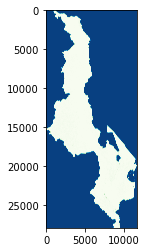

In [29]:
Malawi_OK_Slopes = np.where(array_slopes <= 33.333,1,0)
Malawi_OK_Slopes
plt.figure()
plt.imshow(Malawi_OK_Slopes, cmap="GnBu")

In [30]:
Malawi_OK_Slopes_tif = Malawi_OK_Slopes+1

In [31]:
# Convert array to .tif
ds = gdal.Open("MN_elev_masked.tif")
gt = ds.GetGeoTransform()
proj = ds.GetProjection()

driver = gdal.GetDriverByName("GTiff")
driver.Register()
outds = driver.Create("Malawi_OK_Slopes_tif.tif",xsize = Malawi_OK_Slopes_tif.shape[1],ysize = Malawi_OK_Slopes_tif.shape[0],bands=1,eType = gdal.GDT_Int16)

outds.SetGeoTransform(gt)
outds.SetProjection(proj)
outband = outds.GetRasterBand(1)

outband.WriteArray(Malawi_OK_Slopes_tif)

outband.SetNoDataValue(np.nan)

outband.FlushCache()

outband = None
outds = None

## Landcover

#### Water

In [127]:
# Extract all cells that are water

#### Reclassify to be the same value

In [9]:
ds_water = gdal.Open('Malawi_Landcover/Malawi_Landcover_2010_Sch.tif')
gt_water =ds_water.GetGeoTransform()
proj_water = ds_water.GetProjection()
band_water = ds_water.GetRasterBand(1)
array_water = band_water.ReadAsArray()
array_water

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [33]:
array_water.shape

(28060, 11713)

In [10]:
water = np.where(array_water == 4,0,1)

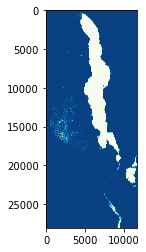

In [35]:
plt.figure()
plt.imshow(water, cmap="GnBu")

In [131]:
# Buffer water by 3 cells (90m)

#Convert water from 3's to 1's to make the buffer work (1 being water present)
water_1 = water/3
water_1

In [11]:
# Buffer by 3 cells

from scipy.ndimage import minimum_filter
buffer_size = 3
water_buffered = minimum_filter(water, size=2*buffer_size+1, mode='constant', cval=1)

In [12]:
water_buffered_tif = water_buffered+1
water_buffered_tif

array([[2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       ...,
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2]])

In [26]:
# Convert array to .tif
ds = gdal.Open("Malawi_Landcover/Malawi_Landcover_2010_Sch.tif")
gt = ds.GetGeoTransform()
proj = ds.GetProjection()

driver = gdal.GetDriverByName("GTiff")
driver.Register()
outds = driver.Create("malawi_water_buffered_tif.tif",xsize = water_buffered_tif.shape[1],ysize = water_buffered_tif.shape[0],bands=1,eType = gdal.GDT_Int16)

outds.SetGeoTransform(gt)
outds.SetProjection(proj)
outband = outds.GetRasterBand(1)

outband.WriteArray(water_buffered_tif)

outband.SetNoDataValue(np.nan)

outband.FlushCache()

outband = None
outds = None

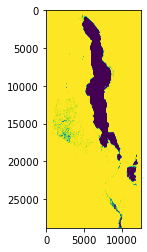

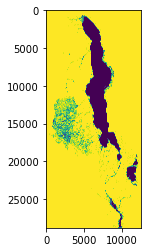

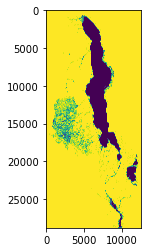

<AxesSubplot:>

In [224]:
#show(water)
#show(water_buffered)
#show(water_buffered_tif)

#### Forest

In [137]:
# Extract all cells that are forest

#### Reclassify to be the same value

In [14]:
ds_forest = gdal.Open('Malawi_Landcover/Malawi_Landcover_2010_Sch.tif')
ds_forest

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f4d76116930> >

In [15]:
gt_forest =ds_forest.GetGeoTransform()
gt_forest

(32.67625,
 0.000276805448836525,
 0.0,
 -9.365138888888906,
 0.0,
 -0.000276827433277896)

In [16]:
proj_forest = ds_forest.GetProjection()
proj_forest

'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'

In [17]:
band_forest = ds_forest.GetRasterBand(1)
band_forest

<osgeo.gdal.Band; proxy of <Swig Object of type 'GDALRasterBandShadow *' at 0x7f4d5d39c2d0> >

In [18]:
array_forest = band_forest.ReadAsArray()
array_forest

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [143]:
#plt.figure()
#plt.imshow(array_forest)

In [144]:
#Not needed for Malawi
#forest_41 = np.where(array_forest == 41,0,1)
#forest_41

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

In [19]:
forest = np.where(array_forest == 1,0,1)
forest

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

In [146]:
#Not needed for Malawi
#forest_43 = np.where(array_forest == 43,0,1)
#forest_43

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

In [147]:
#forest = forest_41 + forest_42 + forest_43

#### Buffer forested areas by 5 cells (150m)

In [22]:
# Buffer by 5 cells

from scipy.ndimage import minimum_filter
buffer_size = 5
forest_buffered = minimum_filter(forest, size=2*buffer_size+1, mode='constant', cval=1)

In [23]:
forests = forest_buffered+1

In [27]:
# Convert array to .tif
ds = gdal.Open("Malawi_Landcover/Malawi_Landcover_2010_Sch.tif")
gt = ds.GetGeoTransform()
proj = ds.GetProjection()

driver = gdal.GetDriverByName("GTiff")
driver.Register()
outds = driver.Create("malawi_forest.tif",xsize = forests.shape[1],ysize = forests.shape[0],bands=1,eType = gdal.GDT_Int16)

outds.SetGeoTransform(gt)
outds.SetProjection(proj)
outband = outds.GetRasterBand(1)

outband.WriteArray(forests)

outband.SetNoDataValue(np.nan)

outband.FlushCache()

outband = None
outds = None

### Vegetation

In [150]:
# Extract all vegetated and agricultural landcover

In [151]:
# Reclassify to be the same value

In [28]:
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt

In [29]:
ds_veg = gdal.Open('Malawi_Landcover/Malawi_Landcover_2010_Scheme_I.tif')
ds_veg

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f4d76139690> >

In [30]:
gt_veg=ds_veg.GetGeoTransform()
gt_veg

(32.576663646086196,
 0.00027682822193849385,
 0.0,
 -9.26266770167673,
 0.0,
 -0.0002768282219384937)

In [31]:
proj_veg = ds_veg.GetProjection()
proj_veg

'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'

In [32]:
band_veg = ds_veg.GetRasterBand(1)
band_veg

<osgeo.gdal.Band; proxy of <Swig Object of type 'GDALRasterBandShadow *' at 0x7f4d5d39c6c0> >

In [33]:
array_veg = band_veg.ReadAsArray()
array_veg

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [  0,   0,   0, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [34]:
veg = np.where(array_veg == 3,1,0)
veg

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [159]:
#Not needed for Malawi
#veg_81 = np.where(array_veg == 81,1,0)
#veg_81

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [160]:
#Not needed for Malawi
#veg_82 = np.where(array_veg == 82,1,0)
#veg_82

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [161]:
#vegetation = veg_71 + veg_81 + veg_82

In [6]:
plt.figure()
plt.imshow(veg)

NameError: name 'plt' is not defined

In [35]:
# Convert array to .tif
ds = gdal.Open("Malawi_Landcover/Malawi_Landcover_2010_Sch.tif")
gt = ds.GetGeoTransform()
proj = ds.GetProjection()

driver = gdal.GetDriverByName("GTiff")
driver.Register()
outds = driver.Create("malawi_veg.tif",xsize = veg.shape[1],ysize = veg.shape[0],bands=1,eType = gdal.GDT_Int16)

outds.SetGeoTransform(gt)
outds.SetProjection(proj)
outband = outds.GetRasterBand(1)

outband.WriteArray(veg)

outband.SetNoDataValue(np.nan)

outband.FlushCache()

outband = None
outds = None

## Summation

In [54]:
veg.shape

(28802, 12533)

In [55]:
Malawi_OK_Slopes.shape

(27964, 11672)

In [56]:
forest_buffered.shape

(28060, 11713)

In [166]:
elevation.crs

CRS.from_epsg(26915)

In [36]:
#Add all the final maps up
summation = veg + forest_buffered + water_buffered + Malawi_OK_Slopes
summation

ValueError: operands could not be broadcast together with shapes (28802,12533) (28060,11713) 

In [ ]:
final_suitability_minnesota = np.where(summation == 4,1,0)
final_suitability_minnesota
plt.figure()
plt.imshow(final_suitability_study_area)

In [ ]:
final_suitability_study_area_tif = final_suitability_study_area + 2

In [ ]:
# Convert array to .tif
ds = gdal.Open("NLCD_Study_Area.tif")
gt = ds.GetGeoTransform()
proj = ds.GetProjection()

driver = gdal.GetDriverByName("GTiff")
driver.Register()
outds = driver.Create("study_area_suitability.tif",xsize = final_suitability_study_area_tif.shape[1],ysize = final_suitability_study_area_tif.shape[0],bands=1,eType = gdal.GDT_Int16)

outds.SetGeoTransform(gt)
outds.SetProjection(proj)
outband = outds.GetRasterBand(1)

outband.WriteArray(final_suitability_study_area_tif)

outband.SetNoDataValue(np.nan)

outband.FlushCache()

outband = None
outds = None

# From ArcGIS

In [18]:
ds_final = gdal.Open('final_mn_suitability.tif')
gt_final =ds_final.GetGeoTransform()
proj_final = ds_final.GetProjection()
band_final = ds_final.GetRasterBand(1)
array_final = band_final.ReadAsArray()
array_final

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

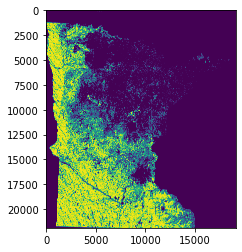

<AxesSubplot:>

In [19]:
show(array_final)

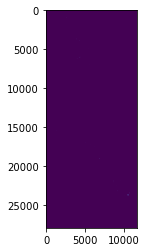

<AxesSubplot:>

In [10]:
malawi_mesonet = np.where(array_final == 6,1,0)
show(malawi_mesonet)

In [15]:
malawi_mesonet

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [21]:
np.savetxt("Minnesota_Final.csv", array_final, delimiter = ',')

In [11]:
# Convert array to .tif
ds = gdal.Open("ArcGIS/malawi_mesonet_union.tif")
gt = ds.GetGeoTransform()
proj = ds.GetProjection()

driver = gdal.GetDriverByName("GTiff")
driver.Register()
outds = driver.Create("malawi_finished.tif",xsize = malawi_mesonet.shape[1],ysize = malawi_mesonet.shape[0],bands=1,eType = gdal.GDT_Int16)

outds.SetGeoTransform(gt)
outds.SetProjection(proj)
outband = outds.GetRasterBand(1)

outband.WriteArray(malawi_mesonet)

outband.SetNoDataValue(np.nan)

outband.FlushCache()

outband = None
outds = None

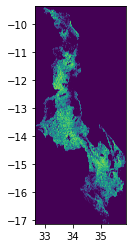

<AxesSubplot:>

In [12]:
arcgis = rasterio.open('ArcGIS/malawi_mesonet_union.tif')
show(arcgis)

In [14]:
np.where(malawi_mesonet = 6)

TypeError: where() got an unexpected keyword argument 'malawi_mesonet'